# Obliczenia hybrydowe

W przypadku obliczeń (kwantowych) `hybrydowe` oznacza strategię mieszania klasycznych i kwantowych obliczeń. 
Idea ta jest podstawowym elementem optymalizacji obwodów wariacyjnych, gdzie kwantowy obwód optymalizowany jest z wykorzystaniem klasycznego ko-procesora.

Najczęściej, obwody (i komputery) kwantowe będziemy wykorzystywać do oszacowania (obliczania) średnich z wyników pomiarów (wartość oczekiwana obserwabli),
które złozyć mozna do pojedynczej klasycznej funkcji kosztu. 
Pozwola nam to oszacować jak dobrze wybrane obwody kwantowe dopasowują się do danych. 
Przykładem moze być model realizowany jako `variational quantum eigensolver` [Peruzzo 2013](https://arxiv.org/abs/1304.3061)

![](../img/vqa.png)


W ogólności łatwo wyobrazić sobie bardziej interesujący sposób w którym mozna łączyć składniki klasyczne i kwantowe w większy i bardziej złozony układ
Kazdy element (czy to kwantowy czy klasyczny) mozna w takim obrazku przedstawić jako klasyczny bądź kwantowy `node`. 

Klasyczne i kwantowe nody mozemy składać w dowolny acykliczny graf (DAG). 
Informacja w takim grafie przebiega w ustalonym kierunku oraz nie występują w nim cykle (pętle). 

Struktura takiego DAG'a powinna być juz nam znajoma. 
Jednym z przykładów są sieci neuronowe. 

Poniewaz mozemy obliczać gradienty variacyjnych obwodów kwantowych, obliczenia hybrydowe są kompatybilne z algorytmem propagacji wstecznej.
Potwierdza to mozliwość trenowania obwodów kwantowych w taki sam sposób w jaki trenuje sie klasyczne sieci neuronowe. 

W ponizszym kodzie przedstawiono realizację sieci neuronowej dla której jedna z warstw ukrytych zastąpiona została obwodem kwantowym. 
Cały kod zrealizowany został w bibliotece PyTorch i pennylane.

In [ ]:
import pennylane as qml
from pennylane import numpy as np

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd

from IPython.display import clear_output

print(f"Torch version: {torch.__version__}")
print(f"mac processor: {torch.backends.mps.is_available()}")

def train(X, Y, model, optimiser, iteration, lossfn, callback = None):
    """ Dodatkowa funkcja pozwalająca wykonać trenowanie naszej sieci neuronowej"""
    for i in range(iteration):
        optimiser.zero_grad()
        prediction = model(X)
        loss = lossfn(Y, prediction)
        loss.backward()
        optimiser.step()
        if callback != None: 
            callback(model, loss)

# dodatkowe ustawienia
torch.manual_seed(123)


Torch version: 2.5.1
mac processor: True


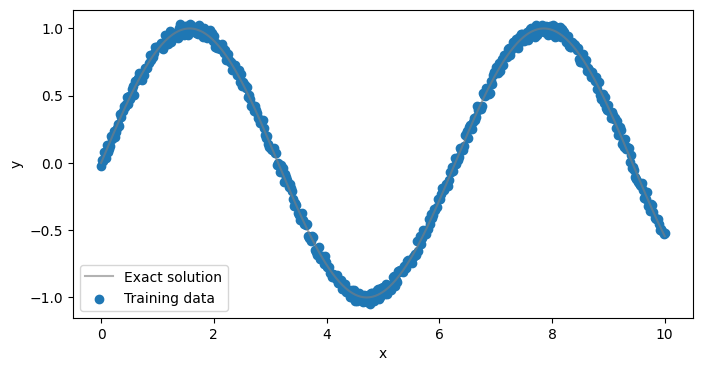

In [2]:
# DANE - funkcja sinus z drobnym szumem
x = torch.linspace(0,10,500).view(-1,1)
y = torch.sin(x)
y = y + 0.1*(torch.rand(500).view(-1,1)-0.5)

plt.figure(figsize=(8,4))
plt.plot(x, torch.sin(x).view(-1,1), color="tab:grey", alpha=0.6, label="Exact solution")
plt.scatter(x, y, label="Training data")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [ ]:
class QN(nn.Module):
    '''Classical -> Quantum -> Classical'''

    def __init__(self, N_INPUT: int, N_OUTPUT: int, Q_NODE, N_QUBITS):
        super().__init__()

        self.layers = nn.Sequential(
            # input layer
            nn.Linear(N_INPUT, N_QUBITS),
            # 1st hidden layer as a quantum circuit
            Q_NODE,
            # output layer
            nn.Linear(N_QUBITS, N_OUTPUT)
        )
        

    def forward(self, x):
        return  self.layers(x)

    
def mse(y, y_pred) -> torch.Tensor:
    return torch.mean((y-y_pred)**2)


n_qubits = 2

# NASZ kwantowy PQC - parametryzowany obwód kwantowy dla jednej warstwy ukrytej
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]


n_layers = 5
weight_shapes = {"weights": (n_layers, n_qubits)}
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

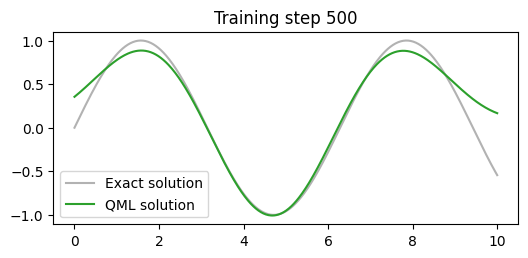

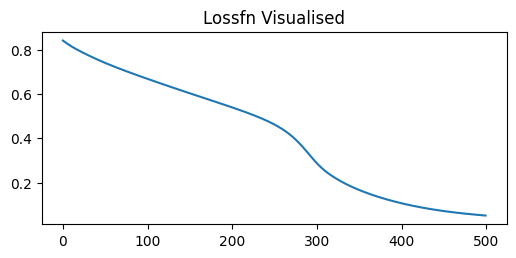

In [4]:
qmodel = QN(1, 1, qlayer, n_qubits)

#print(qmodel)

x = x.requires_grad_(True)
x_train = x.requires_grad_(True)

learning_rate=1e-3
optimiser = torch.optim.Adam(qmodel.parameters(), lr=learning_rate)

losses = []

def callback(model, loss):
    losses.append(loss.item())

    clear_output(wait=True)
    prediction = model(x).detach()
    plt.figure(figsize=(6,2.5))
    plt.plot(x[:,0].detach(), torch.sin(x)[:,0].detach(), label="Exact solution", color="tab:grey", alpha=0.6)
    plt.plot(x[:,0].detach(), prediction[:,0], label="QML solution", color="tab:green")
    plt.title(f"Training step {len(losses)}")
    plt.legend()
    plt.show()

    plt.figure(figsize=(6,2.5))
    plt.title('Lossfn Visualised')
    plt.plot(losses)
    plt.show()

def special_loss_fn(y, y_pred) -> torch.Tensor:
    return mse(y, y_pred) + torch.mean((y_pred - torch.sin(x))**2)
    


train(x_train, y, qmodel, optimiser, 500, special_loss_fn, callback)

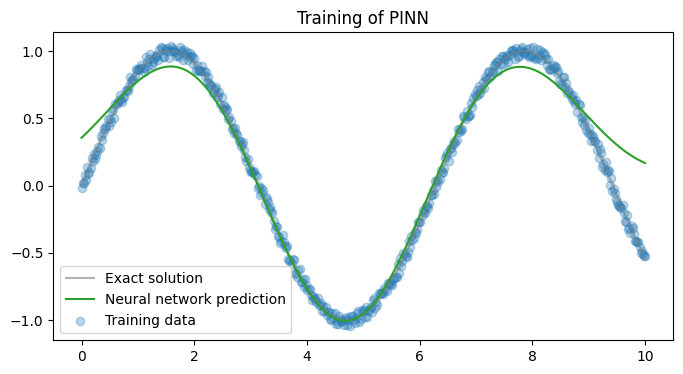

In [5]:
def plot_result(x,y,x_data,y_data,yh, title=None):

    plt.figure(figsize=(8,4))
    plt.title(title)
    plt.plot(x,y, color="tab:grey", alpha=0.6, label="Exact solution")
    plt.plot(x,yh, color="tab:green", label="Neural network prediction")
    plt.scatter(x_data, y_data, alpha=0.3, label='Training data')
    l = plt.legend(loc='best')

plot_result(
    x.detach(),
    torch.sin(x).detach(),
    x.detach(),
    y.detach(),
    qmodel(x).detach(),
    title='Training of PINN'
    )

In [6]:
mse(qmodel(x), torch.sin(x))

tensor(0.0246, grad_fn=<MeanBackward0>)